# A/B test 실습

In [5]:
library("tidyverse");
rawdata<-read_csv("rawdata.csv",show_col_types = FALSE) %>% mutate(order_yn=(order_cnt>0)+0)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0   10004   16305   20250   28000   88810 

[[2]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    9900   14820   19376   24013  129246 

[[3]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    9868   15520   19820   26850   99500 


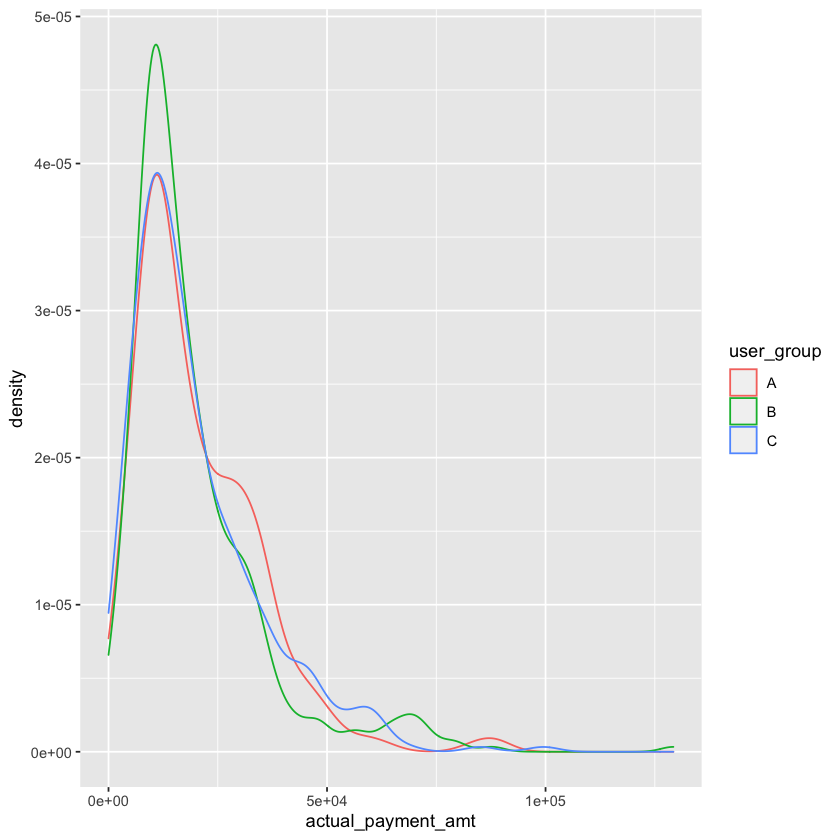

In [6]:
#rawdata %>% group_by(user_group) %>% group_map(~ quantile(.x$actual_payment_amt,prob=seq(0,1,by=0.1)))

#rawdata %>% group_by(user_group) %>% summarise(ratio=mean(order_yn))

dataset <- rawdata %>% filter(order_yn==1) %>% select(user_group,actual_payment_amt) 
dataset %>% group_by(user_group)  %>% group_map(~ summary(.x$actual_payment_amt))
dataset %>% ggplot(aes(x=actual_payment_amt,color=user_group)) + geom_density()
#t.test(dataset=dataset %>% filter(user_group %in% c('A','B')))
#%>% group_by(user_group) %>% summarise(xbar=mean(actual_payment_amt),n=n())
splitSet<-dataset %>% group_by(user_group) %>% group_split()



* 밀도함수로는 판단이 어려움 

## 모수적 접근방법
### 가정검토
#### 1.정규성

In [7]:
dataset %>% group_by(user_group) %>% group_map(~ shapiro.test(.x$actual_payment_amt))

[[1]]

	Shapiro-Wilk normality test

data:  .x$actual_payment_amt
W = 0.87541, p-value = 2.947e-14


[[2]]

	Shapiro-Wilk normality test

data:  .x$actual_payment_amt
W = 0.78599, p-value < 2.2e-16


[[3]]

	Shapiro-Wilk normality test

data:  .x$actual_payment_amt
W = 0.87048, p-value = 2.221e-16



귀무가설 : 데이터가 정규분포를 따른다.  
$\therefore$ 정규분포를 따르지 않음

#### 2.등분산성

In [8]:
var.test(test_set %>% pull(actual_payment_amt)~test_set %>% pull(user_group))

ERROR: Error in pull(., actual_payment_amt): 객체 'test_set'를 찾을 수 없습니다


* 등분산성 만족

### 가설검정
#### t-test 나눠서

In [9]:
test_set<-union_all(splitSet[[1]],splitSet[[3]])
t.test(test_set %>% pull(actual_payment_amt)~test_set %>% pull(user_group),var.equal=TRUE)

test_set<-union_all(splitSet[[2]],splitSet[[3]])
t.test(test_set %>% pull(actual_payment_amt)~test_set %>% pull(user_group),var.equal=TRUE)


	Two Sample t-test

data:  test_set %>% pull(actual_payment_amt) by test_set %>% pull(user_group)
t = 0.36542, df = 620, p-value = 0.7149
alternative hypothesis: true difference in means between group A and group C is not equal to 0
95 percent confidence interval:
 -1880.899  2740.916
sample estimates:
mean in group A mean in group C 
       20249.97        19819.96 



	Two Sample t-test

data:  test_set %>% pull(actual_payment_amt) by test_set %>% pull(user_group)
t = -0.397, df = 766, p-value = 0.6915
alternative hypothesis: true difference in means between group B and group C is not equal to 0
95 percent confidence interval:
 -2638.179  1750.610
sample estimates:
mean in group B mean in group C 
       19376.17        19819.96 


#### ANOVA 

In [10]:
fit <- aov(actual_payment_amt~user_group, dataset)
summary(fit)

              Df    Sum Sq   Mean Sq F value Pr(>F)
user_group     2 1.304e+08  65203445   0.287  0.751
Residuals   1043 2.371e+11 227362370               

##### 사후분석 (Tukey)

In [11]:
TukeyHSD(fit)
#pairwise.t.test(dataset %>% pull(actual_payment_amt), dataset %>% pull(user_group), p.adj = "bonf")

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = actual_payment_amt ~ user_group, data = dataset)

$user_group
         diff       lwr      upr     p adj
B-A -873.7931 -3604.947 1857.361 0.7331447
C-A -430.0083 -3284.157 2424.140 0.9334058
C-B  443.7848 -2124.253 3011.823 0.9133290


## 비모수접근
### wilcoxon rank sum test 나눠서

In [12]:
test_set<-union_all(splitSet[[1]],splitSet[[3]])
wilcox.test(test_set %>% pull(actual_payment_amt)~test_set %>% pull(user_group))

test_set<-union_all(splitSet[[2]],splitSet[[3]])
wilcox.test(test_set %>% pull(actual_payment_amt)~test_set %>% pull(user_group))


	Wilcoxon rank sum test with continuity correction

data:  test_set %>% pull(actual_payment_amt) by test_set %>% pull(user_group)
W = 49712, p-value = 0.3948
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  test_set %>% pull(actual_payment_amt) by test_set %>% pull(user_group)
W = 71166, p-value = 0.5644
alternative hypothesis: true location shift is not equal to 0


### kruskal-wallis test

In [15]:
kruskal.test(actual_payment_amt~user_group,data=dataset)


	Kruskal-Wallis rank sum test

data:  actual_payment_amt by user_group
Kruskal-Wallis chi-squared = 2.2768, df = 2, p-value = 0.3203


##### 사후분석(Dunn Test)

In [16]:
library('FSA')
dunnTest(actual_payment_amt~user_group,data=dataset,)

Warning message:
“user_group was coerced to a factor.”
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Holm method.




  Comparison          Z   P.unadj     P.adj
1      A - B  1.5086214 0.1313956 0.3941867
2      A - C  0.8957479 0.3703874 0.7407748
3      B - C -0.6089006 0.5425903 0.5425903